In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

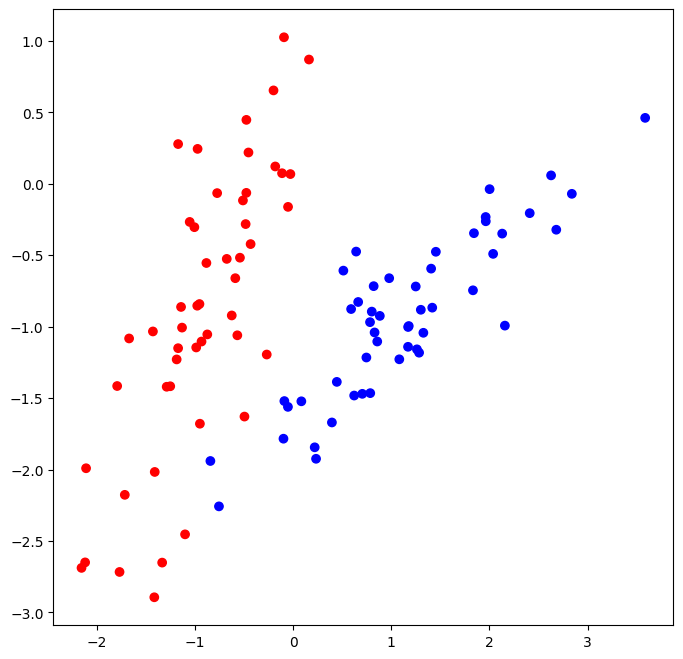

In [ ]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

In [ ]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        dict = {}

        for classes in self.labels:
            if dict.get(classes) == None:
                dict[classes] = 1
            else:
                dict[classes] += 1

        mx = 0
        cls = -100

        for classes in dict.keys():
            if mx < dict[classes]:
                mx = dict[classes]
                cls = classes

        return cls

def gini(labels):
    dict = {}

    n = len(labels)

    for classes in labels:
        if dict.get(classes) == None:
            dict[classes] = 1
        else:
            dict[classes] += 1

    impurity = 0

    for classes in dict.keys():
        prob = dict[classes] / n
        impurity += prob * (1 - prob)

    return impurity

def quality(left_labels, right_labels, current_gini):
    n = len(left_labels)
    m = len(right_labels)

    return current_gini - gini(left_labels) * (n / (n + m)) - gini(right_labels) * (m / (n + m))

def split(data, labels, index, t):
    condition = data[:, index] >= t

    true_data = data[condition]
    false_data = data[~condition]

    true_labels = labels[condition]
    false_labels = labels[~condition]

    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels):
    best_quality = 0
    best_t = 0
    best_index = -1

    current_gini = gini(labels)

    for index in range(data.shape[1]):
        unique_values = set(data[:, index])

        for t in unique_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            q = quality(true_labels, false_labels, current_gini)

            if q > best_quality:
                best_quality = q
                best_t = t
                best_index = index

    return current_gini - best_quality, best_t, best_index

def build_tree(data, labels):
    min_split = 5
    best_quality, best_t, best_index = find_best_split(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)

    if best_quality == 0:
        return Leaf(data, labels)

    if len(true_data) >= min_split:
        true_branch = build_tree(true_data, true_labels)
    else:
        true_branch = Leaf(true_data, true_labels)

    if len(false_data) >= min_split:
        false_branch = build_tree(false_data, false_labels)
    else:
        false_branch = Leaf(false_data, false_labels)
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(best_index, best_t, true_branch, false_branch)

def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction

    if obj[node.index] < node.t:
        return classify_object(obj, node.false_branch)

    return classify_object(obj, node.true_branch)

def predict(data, tree):
    ans = []
    for obj in data:
        ans.append(classify_object(obj, tree))

    return ans

In [ ]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)


In [ ]:
my_tree = build_tree(train_data, train_labels)

In [ ]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)

Индекс 0
Порог 0.22079911434425847
--> True:
  Прогноз: 1
--> False:
  Индекс 1
  Порог -1.4172393321608008
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.8411814419026544
    --> True:
      Индекс 0
      Порог -0.09712237000978252
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 0


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred_test = predict(train_data, my_tree)

In [ ]:
accuracy_score(pred_test, train_labels)

0.9857142857142858

In [ ]:
pred_train = predict(test_data, my_tree)

In [ ]:
accuracy_score(pred_train, test_labels)

1.0

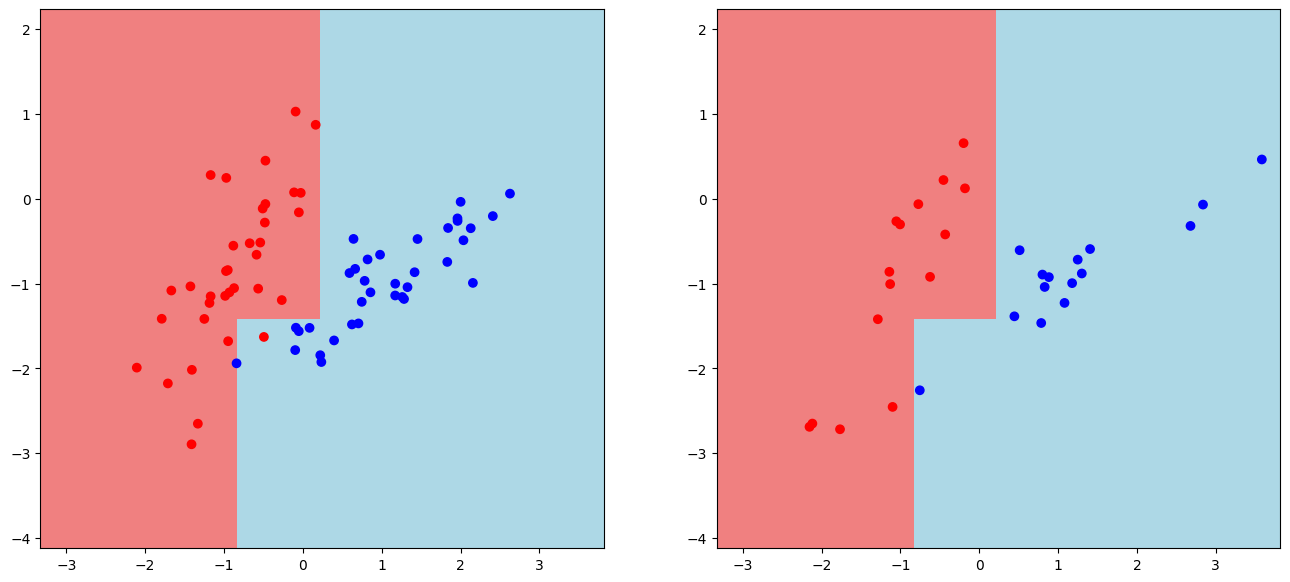

In [ ]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

#print(np.c_[xx.ravel(), yy.ravel()])

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
#plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
#plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()
